### Understanding Graph Convolutions

Graph convolutions are pivotal to graph neural networks (GNNs). To understand graph convolutions, it's helpful to first consider convolutions in the context of images. In image processing, convolution operations involve applying a filter or kernel to an image. This filter moves systematically over the image, performing element-wise multiplication with the part of the image it covers and adding up these products to create a new, transformed image.

Graphs differ from images in that they do not have a regular, grid-like structure. Instead, they consist of nodes (vertices) and edges (connections or relationships), which are not arranged in any fixed, orderly pattern. This lack of structure presents a unique challenge for applying convolution operations, as there is no straightforward way to "slide" a kernel over the nodes of a graph.

Graph convolutions redefine the convolution operation to suit the unique structure of graphs. The idea is to aggregate information from nodes' neighborhood (i.e., the immediate connections of a node) by computing a weighted sum of the adjacent node features. The weights can be determined in various ways, often involving the properties of the edges or the nodes themselves. 

The graph connectivity defines how information flows during convolution. This connectivity is often represented by an adjacency matrix $A$, where each entry $A_{ij}$ is set to 1 if there is a link between nodes $i$ and $j$, and 0 otherwise. $A$ can represent both directed and undirected graphs. In a directed graph, an entry $A_{ij}​=1$ implies a directed edge from node $i$ to node $j$, indicating the direction of information flow. Conversely, in undirected graphs, $A_{ij} = A_{ji} = 1$ reflects bidirectional edges, allowing information to flow in both directions. This structure underpins the aggregation process in graph convolution, steering the feature integration from neighboring nodes to capture the graph's topology. 

As an example, consider a simple cycle graph.

In [3]:
import numpy as np

nnodes = 5

# (1-2): Create an adjacency matrix
A = np.zeros((nnodes, nnodes))  # (1)
for i in range(nnodes):
    A[i, (i + 1) % nnodes] = 1  # (2)

# (3): Create node features
x = np.pad([1], (0, nnodes - 1), "constant", constant_values=(0))

print("A:\n", A, "\n")
print("x:", x)

A:
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]] 

x: [1 0 0 0 0]


This code defines a graph with an adjacency matrix `A`, (1) initially filled with zeros. (2) This matrix is later updated to represent connections where each node is cyclically linked to the next node. 

(3) A graph signal `x` (representing the node features) is also initialized with the first node set to 1 and the rest set to 0.

In [4]:
def GraphConvolution(A, x):
    return A @ x 

convolved_x = []
for _ in range(nnodes): # (1)
    x = GraphConvolution(A, x) # (2)  
    convolved_x.append(x) # (3)

print("Output sequence of convolved node features:")
for i, x in enumerate(convolved_x):
    print(f"Convolution {i + 1}:", x) # (4)

Output sequence of convolved node features:
Convolution 1: [0. 0. 0. 0. 1.]
Convolution 2: [0. 0. 0. 1. 0.]
Convolution 3: [0. 0. 1. 0. 0.]
Convolution 4: [0. 1. 0. 0. 0.]
Convolution 5: [1. 0. 0. 0. 0.]


(1) A loop runs for the number of nodes in the graph. (2) During each iteration, the node features vector `x` is updated through a graph convolution operation. This operation involves multiplying the adjacency matrix `A` by the current node features vector to simulate the spread of features across the graph. Here, the updated feature for each node is computed as the sum of the features of its neighbors. (3) The resulting feature vector is stored in the `convolved_x` list to (4) keep track of changes over each iteration.

In [5]:
import numpy as np

node_num = 5

A = np.zeros((node_num, node_num))
for i in range(node_num):
    for j in range(node_num):
        if j % node_num == (i + 1) % node_num:
            A[i, j] = 1
print("A:\n", A)


x = np.zeros(node_num)
x[0] = 1
print("x:", x)

def graph_convolution(A, x):
    """Calculate graph convolution."""
    conv = np.zeros(node_num)
    for i in range(node_num):
        for j in range(node_num):
            conv[j] += A[i, j] * x[i]
    return conv

for c in range(5):
    x = graph_convolution(A, x)
    print(f"Convolution {c + 1}:", x)


A:
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
x: [1. 0. 0. 0. 0.]
Convolution 1: [0. 1. 0. 0. 0.]
Convolution 2: [0. 0. 1. 0. 0.]
Convolution 3: [0. 0. 0. 1. 0.]
Convolution 4: [0. 0. 0. 0. 1.]
Convolution 5: [1. 0. 0. 0. 0.]


### Implementing Graph Convolution Layer

We will now delve into implementing a Graph Convolution Layer (GCL). You will find out that moving from theory to implementation is straightforward since the fundamental concept of graph convolution remains the same. Yet, a few extra considerations are needed for implementing a GCL.


#### The Fingerprint of a GCL

Although implementing GCLs can vary, it typically involves three sequential operations, i.e., **Transform**, **Propagate**, and **Update**.

**Transform** is the initial step, where each node's features are transformed through a *learnable* function. This transformation prepares the node features for further processing, allowing the GCL to learn complex representations of the nodes' attributes. 

**Propagate** is responsible for the diffusion of information across the graph. During this phase, each node's transformed features are shared with its neighbors, allowing for information aggregation from node's local neighborhood. 

Finally, **Update**  refines each node's features based on the aggregated information collected during the propagation step. This typically involves applying another learnable function to the aggregated features or a non-linear activation function.

In [58]:
import torch
import torch.nn as nn

#from deeplay import DeeplayModule, Layer
import deeplay as dl

class GraphConvolution(nn.Module):
    def forward(self, A, x):
        return A @ x

class GCL(dl.DeeplayModule):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        
        self.Transform = dl.Layer(nn.Linear, in_features, out_features)
        self.Propagate = dl.Layer(GraphConvolution)
        self.Update = dl.Layer(nn.ReLU)

    def forward(self, A, x):
        x = self.Transform(x)
        x = self.Propagate(A, x)
        x = self.Update(x)
        return x

This code implements a simple `GCL` comprising the `Transform`, `Propagate`, and `Update` operations.

`Transform` is implemented as a linear layer that takes the node features `x` (with `in_features` dimensions) and transforms them into a new feature space with `out_features` dimensions. 

`Propagate` is implemented as a matrix multiplication between the adjacency matrix `A` and the transformed node features. Note this operation is equivalent to the graph convolution operation implemented in the previous example. 

Once the transformed features are propagated across the graph, the `Update` operation applies a non-linear activation function (ReLU) to the aggregated features to produce the final node features.

#### Functional, yet not practical

Before proceeding, it is essential to note that the `GCL` implementation is functional but not practical. This is because two major limitations hinder its effectiveness in real-world scenarios.

First, our current implementation of `GraphConvolution` aggregates features from neighboring nodes, but it does not consider the attributes of the nodes themselves. The significance of this shortfall cannot be overstated, as in real-world scenarios, node's intrinsic attributes often play a pivotal role in the convolution operation, influencing the outcome and effectiveness of the model.

The second major limitation revolves around the lack of normalization within $A$. Normalization is crucial in ensuring that the aggregation of features across nodes is balanced and meaningful. Without normalization, nodes with a higher degree (i.e., a greater number of neighbors) will naturally result in larger aggregated feature values than those with fewer neighbors. This discrepancy can lead to a pronounced variance in the aggregated features, potentially skewing the model's performance and its ability to generalize across the graph. 

To solve these issues, [Kipf and Welling (2017)](https://arxiv.org/abs/1609.02907) proposed a simple yet effective solution that addresses both limitations. Their approach introduces self-loops to the adjacency matrix and normalizes the aggregated features. This normalization is achieved by dividing the aggregated features by the square root of the product of the degree of the source and target nodes.

In [7]:
class GraphConvolution(nn.Module):
    def normalize(self, A):
        A = A + torch.eye(A.size(0)).to(A.device) # (1)

        deg = torch.sum(A, dim=1)
        deg = deg.pow(-0.5)
        deg[deg == float("inf")] = 0
        D = torch.diag(deg) # (2)

        A_norm = D @ A @ D
        return A_norm

    def forward(self, A, x):
        A_norm = self.normalize(A) #(3)
        return A_norm @ x # (4)

This code adds `self.normalize` to the `GraphConvolution` class. This method (1) adds self-loops to the adjacency matrix and (2) normalizes `A` by dividing its entries by the square root of the product of the degree of the source and target nodes. 

 (3-4) The normalized adjacency matrix is then used to propagate the transformed features across the graph.

### Implementing a Graph Convolutional Network for Molecular Property Prediction

We will now apply our GCL to a real-world problem: molecular property prediction. This task involves predicting the properties of molecules based on their structural information. 

##### The ZINC dataset

We will use the ZINC dataset, a molecular graph dataset in which the task is to regress the penalized water-octanol partition coefficient (logP) of molecules. This coefficient is a measure widely used in drug discovery. 

For reproducibility, we will use the splits provided by Dwivedi et al. (2020) in their paper ["Benchmarking Graph Neural Networks"](https://arxiv.org/abs/2003.00982): 10,000 molecules for training, 1,000 for validation, and 1,000 for testing.

We start by downloading the dataset using the following code snippet, which automatically downloads and prepares the data:

In [8]:
from torch_geometric.datasets import ZINC

train_dataset = ZINC(root='ZINC_dataset/', subset=True, split='train')
val_dataset = ZINC(root='ZINC_dataset/', subset=True, split='val')
test_dataset = ZINC(root='ZINC_dataset/', subset=True, split='test')

##### Visualizing the dataset

In the dataset, molecules are represented as a graph, with nodes and edges describing atoms and chemical bonds, respectively. 

Let us write a function that displays the structures of a molecule by visualizing their adjacency matrices. 

The input to the function is a graph comprising the following attributes: `x` (node features), `edge_index` (edge connectivity), and `y` (target property).

(1) The adjacency matrix `A` is computed from the `edge_index` tensor. `edge_index` stores the indices of the nodes connected by an edge. We convert `edge_index` into an adjacency matrix `A` for better visualization and alignment with our graph convolution implementation.

(2) As explained earlier, nodes represent atoms, with features describing the atom type. These features are stored in the `x` attribute of the graph as a tensor of shape `(num_nodes, 1)`. 

(3) Next, the adjacency matrix `A` is plotted, with each entry colored according to the value of the adjacency matrix. A value of 1 is colored in yellow, while 0 is colored in blue. The atom type is also displayed on every (4) row and (5) column. 

(6) Finally, the target property, logP (stored in the `y` attribute), is printed.

We can now visualize the structure of three randomly selected molecules from the dataset using the `plot_molecule` function.

In [51]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

def plot_molecule(molecule):
    """Plot adjacency matrix of a molecule."""
    x = molecule["x"].numpy().squeeze()
    A = to_dense_adj(molecule["edge_index"]).numpy().squeeze(0)
    y = molecule["y"].item()
    
    fig, ax = plt.subplots()
    ax.matshow(A, cmap='viridis')

    indices = np.arange(len(x))
    ax.set_xticks(indices, x, fontsize=12)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Atom type', fontsize=16)
    
    ax.set_yticks(indices, x, fontsize=12)
    ax.set_ylabel('Atom type', fontsize=16)

    ax.set_title(f"LogP={np.round(y, 2)}", fontsize=24)

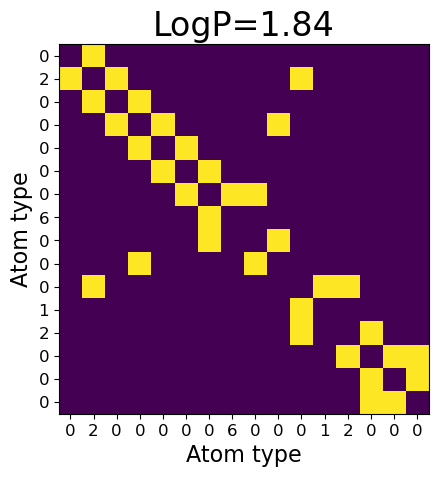

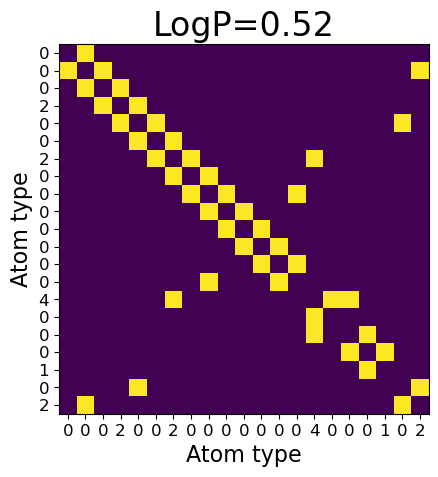

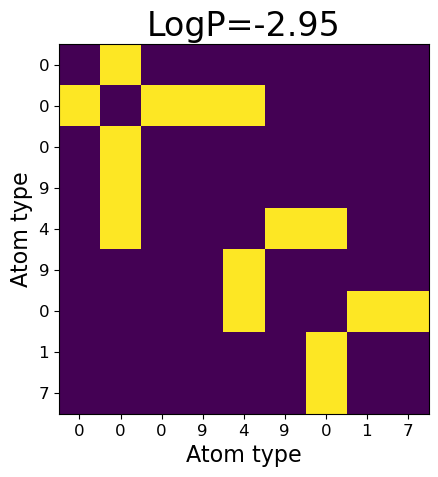

In [56]:
for i in [2, 1235, 9887]:
    plot_molecule(molecule=train_dataset[i])

In [42]:
graph["y"]

tensor([-2.9462])

#### Building a Graph Convolutional Network

A Graph Convolutional Network (GCN), in its simplest form, consists of a series of graph convolution layers.

The following code defines a simple GCN model. 

In [60]:
class GCN(dl.DeeplayModule):
    """Graph convolutional network."""
    
    def __init__(self, in_features, hidden_features, out_features):
        """Initialize graph convolutional network."""
        super().__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.blocks = dl.LayerList()
        for f_in, f_out in zip([in_features, *hidden_features], 
                               [*hidden_features, out_features]):
            self.blocks.append(GCL(f_in, f_out))

    def forward(self, G):
        """Calculate forward pass."""
        for block in self.blocks:
            G["x"] = block(G["A"], G["x"])
        return G["x"]

The model architecture consists of a stack of GCLs, (1) initialized as an empty list of layers, yet later (2-3) populated with `GCL` instances. 

The input to the model is a graph `G`, which contains the node features `x` and the adjacency matrix `A`. The graph is passed through each GCL in the list, with the output of each layer serving as the input to the next layer.

Importantly, the model is not yet complete. Three additional components are needed to make the model functional for our molecular property prediction task: 

1. In the ZINC dataset, nodes represent atom types encoded as categorical features (i.e., integers). To process such features, we need to use an *embedding layer*, which acts as a lookup table to convert each atom type into a continuous vector representation.

2. The current model outputs features for each node. However, the ultimate goal is to predict the property of the entire molecule (in our case, the logP value). To accomplish this, we need to combine the features of all nodes into a single representation for the entire graph. This can be done using a *global average pooling*, which involves computing the mean of all node features.

3. Finally, a *dense top* is added to the model to perform the regression task. This layer takes the graph-level representation and maps it to a single output value, which is the predicted logP.

Let's add these components to the model.

In [ ]:
class GCN(dl.DeeplayModule):
    """Graph convolutional network."""
    
    def __init__(self, in_features, hidden_features, out_features, 
                 num_node_embedding, embedding_dim):
        """Initialize graph convolutional network."""
        super().__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.node_embedding = dl.Layer(nn.Embedding, num_node_embedding, 
                                       embedding_dim)

        self.blocks = dl.LayerList()
        for f_in, f_out in zip([in_features, *hidden_features], 
                               [*hidden_features, out_features]):
            self.blocks.append(GCL(f_in, f_out))

        self.dense_top = dl.Sequential(
            dl.Layer(nn.Linear, hidden_features[-1], hidden_features[-1] // 4),
            dl.Layer(nn.ReLU),
            dl.Layer(nn.Linear, hidden_features[-1] // 4, out_features),
        )

    def forward(self, G):
        """Calculate forward pass."""
        G["x"] = self.node_embedding(G["x"])
        for block in self.blocks:
            G["x"] = block(G["A"], G["x"])
        
        h = torch.mean(G["x"], dim=0)
        
        return self.dense_top(h)

This code modifies the `GCN` class to include the embedding layer, global average pooling, and dense top.

(1-2) The class receives the number of atom types `num_node_embedding` and the number of embedding dimensions `embedding_dim` as input. These parameters are used to (3) initialize the embedding layer.

(4-6) The dense top is defined as a sequential model comprising two linear layers with a ReLU activation function in between. (4) The first linear layer maps the graph-level representation to a hidden layer, while (6) the second linear layer maps the hidden layer to the output logP value.

(7) The global average pooling operation is added to the forward method to aggregate the node features into a single graph-level representation. This is achieved by computing the mean of the node features across the graph.

#### Batch Processing

The final step in preparing the model is to enable batch processing. This is crucial for training the model, as it allows us to process multiple graphs simultaneously, improving the model's efficiency and scalability.

To enable batch processing, we need to modify the `GCN` class to handle a batch of graphs:

In [ ]:
class GCN(dl.DeeplayModule):
    """Graph convolutional network."""
    
    def __init__(self, in_features, hidden_features, out_features, 
                 num_node_embedding, embedding_dim):
        """Initialize graph convolutional network."""
        super().__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.node_embedding = dl.Layer(nn.Embedding, num_node_embedding, 
                                       embedding_dim)

        self.blocks = dl.LayerList()
        for f_in, f_out in zip([in_features, *hidden_features], 
                               [*hidden_features, out_features]):
            self.blocks.append(GCL(f_in, f_out))

        self.dense_top = dl.Sequential(
            dl.Layer(nn.Linear, hidden_features[-1], hidden_features[-1] // 4),
            dl.Layer(nn.ReLU),
            dl.Layer(nn.Linear, hidden_features[-1] // 4, out_features),
        )

    def forward(self, G):
        """Calculate forward pass."""
        G["x"] = self.node_embedding(G["x"])
        for block in self.blocks:
            G["x"] = block(G["A"], G["x"])
        
        batch_size = torch.max(G["batch"]) + 1
        h = torch.zeros(batch_size, G["x"].shape[1], device=G["x"].device)
        h = h.scatter_add(0, G["batch"][:, None].expand_as(G["x"]), G["x"])
        h = h / torch.bincount(G["batch"])[:, None]
        
        return self.dense_top(h).squeeze()

The forward method is updated to accept a batched graph `G` as input. 

Since graphs can have different numbers of nodes, `G["x"]` stores the node features of all graphs in a single tensor of shape `(total_num_nodes, num_node_features)`. 

Similarly, `G["A"]` stores all the adjacency matrices of the graphs as a block-diagonal matrix with shape`(total_num_nodes, total_num_nodes)`, where each block corresponds to the adjacency matrix of a single graph in the batch.

Last, `G["batch"]` is a tensor of shape `(total_num_nodes)` that stores the graph indices to which each node belongs.

In the forward method, all the operations are performed on the entire batch. This includes the embedding layer, graph convolution layers, global average pooling, and dense top. It's important to note that all the operations are the same as before. However, the graph-level representation is computed for each graph in the batch. To achieve this,

(1) we create a tensor with shape `torch.zeros(batch_dim, x.shape[1])` and initialize it with zeros. 

(2) We apply the `scatter_add` function to this tensor along the first dimension, using `G["batch"][:, None].expand_as(x)` as the index. This results in a tensor with aggregated values, where each row represents the summed node features for the respective graph in the batch. 

Last, (3) we normalize the aggregated features by the number of nodes in each graph to compute the mean node features per graph.

Let us now instantiate the model.

In [ ]:
GCN_model = GCN(
    hidden_features=[64, 64, 64, 64],  
    out_features=1,  
    num_node_embedding=28, # Given by the ZINC dataset (28 atom types)
    embedding_dim=64,  
).create()

print(GCN_model)

#### Defining the data loaders

Before training the model, we need to define the data loaders, which are responsible for feeding the data to the model during training and evaluation.

In [12]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Training the model

We will now proceed to create the `MolecularRegressor` class, which will be responsible for training and evaluating the model. 

This class is designed to handle batch processing, training, and evaluation loops correctly.

In [ ]:
class MolecularRegressor(dl.Regressor):
    """Molecular regressor."""
    
    def __init__(self, model, **kwargs):
        """Initialize molecular regressor."""
        super().__init__(model, **kwargs)

    def batch_preprocess(self, batch):
        """Preprocess batch."""
        batch["x"] = batch["x"].squeeze()
        batch["A"] = to_dense_adj(batch["edge_index"]).squeeze(0)
        return batch.to(self.device)
    
    def forward(self, batch):
        """Calculate forward pass."""
        return self.model(self.batch_preprocess(batch))

The `MolecularRegressor` class implements the `batch_preprocess` method, which is responsible for preparing the input to the model. It comprises the following steps:

(1) The `x` tensor is squeezed. This operation eliminates any singleton dimensions from `x`, ensuring that its shape matches the model requirements.

(2) The adjacency matrix `A` is calculated from the edge index.

Let's instantiate this class and train the model.

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

regresor = MolecularRegressor(
    GCN_model, loss=nn.L1Loss(), optimizer=dl.Adam(lr=1e-3)
).create()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="models", 
    filename="ZINC-GCN-model{epoch:02d}-val_loss{val_loss:.2f}",
    auto_insert_metric_name=False, 
)
trainer = dl.Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(regresor, train_loader, val_loader)

The model is compiled using the (1) using the Mean Absolute Error (MAE) as the loss function and the Adam optimizer.

(2) A checkpoint callback is implemented to save the best model during training. This callback monitors the validation loss and saves the model with the lowest loss in the `dirpath` directory. It's important to note that the filename includes the epoch and the validation loss for easy identification.

(3) The trainer is instantiated specifying the number of epochs and checkpoint callback.

(4) Last, the model is trained with the fit method using the training and validation data loaders as input.

After training the model and saving its weights, we can evaluate it on the test set by loading the best model with the following code snippet.

In [ ]:
import glob
import os

best_model_path = glob.glob(os.path.join("models", "ZINC-GCN-model*.ckpt"))
best_model_path = sorted(best_model_path, key=os.path.getmtime)[-1]
regresor = MolecularRegressor.load_from_checkpoint(
    best_model_path,
    model=GCN_model,
    loss=nn.L1Loss(),
)

test_results = trainer.test(regresor, test_loader)

You should expect an MAE of around 0.46, which is in line with results published in the  [literature](https://arxiv.org/pdf/2205.00354v1.pdf) for GCNs on the ZINC dataset.

#### Visualizing the predictions vs the ground truth

To evaluate the model further, let's create a visualization that compares the predicted logP values with the actual ones.

In [16]:
gts, preds = [], []
for batch in test_loader:
    y = batch.pop("y")
    pred = regresor(batch)  # (2)

    gts.append(y) # (3)
    preds.append(pred) # (4)

preds = torch.cat(preds).detach().cpu().numpy() # (5)
gts = torch.cat(gts).cpu().numpy() # (6)

In the loop, we iterate over the test set. 

Each batch is (1) preprocessed and (2) passed through the model to get the predicted logP values. Then, (3-4) the true and predicted logP values are stored in separate lists.

After finishing the loop, the lists (5-6) are concatenated into tensors and converted to NumPy arrays. 

Finally, the predictions are plotted against the ground truth logP values for visualization.

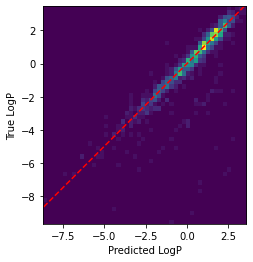

In [17]:
heatmap, xedges, yedges = np.histogram2d(preds, gts, bins=50) # (1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] # (2)

plt.clf()
plt.plot([min(gts), max(gts)], [min(gts), max(gts)], "r--") # (3)
plt.imshow(heatmap.T, extent=extent, origin="lower") # (4)
plt.xlabel("Predicted LogP")
plt.ylabel("True LogP")
plt.show()

This code snippet generates a heatmap to visualize the correlation between predicted and ground truth logP values. 

Initially, (1) `np.histogram2d` is used to compute a 2D histogram for the two data sets, dividing them into 50 bins along each dimension to create the heatmap data. 

(2) The `extent` variable is defined to specify the bounds of the x and y axes based on the edges of the bins, ensuring the heatmap aligns with the actual data range. 

(3) A dashed red line is plotted to represent the ideal case where predicted values equal the true values, serving as a reference for evaluating the predictions. 

Last, (4) `plt.imshow` displays the heatmap with the specified extent and origin.

Note that the predicted logP values are highly correlated with the ground truth values, as indicated by the strong diagonal line in the heatmap. This suggests that the model is effective at predicting the logP values of the molecules in the test set.

### Message Passing in Graph Neural Networks

In the realm of graphs, valuable information is found not only at the node level but also at the edge level. This information, known as edge features, is crucial for capturing relationships between nodes in the graph. For example, in molecular graphs, edge features can represent the type of chemical bond between atoms, essential for understanding the molecule's structure and properties. 

However, a simple Graph Convolutional Layer (GCL) is insufficient to capture the full complexity of the graph when edge features are present. Instead, a more expressive model that utilizes both node and edge features to learn a richer representation of the graph is needed. [Message Passing Layers (MPLs)](https://arxiv.org/pdf/1704.01212.pdf) serve this purpose.


#### The Fingerprint of a MPL

Algorithmically, both MPLs and GCLs share a foundational structure, distilled into three pivotal steps: **Transform**, **Propagate**, and **Update**. Indeed, [GCLs can be viewed as a special case of MPLs](https://arxiv.org/pdf/2104.13478.pdf) (although it is not of our concern here). MPLs, however, uniquely tailor these steps to incorporate edge features, thereby equipping the model with the capability to integrate insights from both nodes and edges.

**Transform** is the initial step, where node and edge features are merged into a single, unified feature vector called *message*. A message is a representation that encodes information about the interaction between two connected nodes.

In [18]:
class TransformLayer(nn.Module):
    def __init__(self, hidden_features):
        super().__init__()

        self.hideen_features = hidden_features

        self.layer = nn.LazyLinear(hidden_features)
        self.activation = nn.ReLU()

    def forward(self, G):
        G["message"] = torch.cat( # (1)
            [
                G["x"][G["edge_index"][0]], 
                G["x"][G["edge_index"][1]],
                G["edge_attr"],
            ],
            dim=-1,
        )
        G["message"] = self.layer(G["message"]) # (2)
        G["message"] = self.activation(G["message"]) # (3)

        return G

Messages are computed by (1) concatenating the source and target nodes' features with the connecting edge features and passing the result through a learnable function, in this case, (1-2) a linear layer followed by a non-linear activation function.

It's important to note that `edge_index` is used instead of `A` to represent graph connectivity. Although both representations are equivalent, `edge_index` is favored in Message Passing Layers (MPLs) because it offers a more intuitive method for accessing graph edges.

Once the messages are computed, **Propagate** is responsible for sharing the messages across the graph. This is achieved by aggregating the messages from neighboring nodes.

In [19]:
class PropagateLayer(nn.Module):
    def __init__(self, hidden_features):
        super().__init__()

        self.hidden_features = hidden_features

    def forward(self, G):
        G["aggregate"] = torch.zeros(G["x"].size(0), self.hidden_features) # (1)
        G["aggregate"] = G["aggregate"].type_as(G["x"])
        G["aggregate"] = G["aggregate"].to(G["x"].device)

        indices = G["edge_index"][1].unsqueeze(1).expand_as(G["message"])  # (2)
        G["aggregate"] = G["aggregate"].scatter_add(0, indices, G["message"]) # (3)

        return G


The aggregation starts by (1) zero-initializing a tensor to store the aggregated messages. This tensor is then adjusted to match the data type and device (e.g., CPU or GPU) of the node features tensor (`G["x"]`), ensuring it is compatible with the computation settings of the input graph data. 

(2) The next step in the process involves preparing the target node indices for each message. This is done by unsqueezing and expanding the target edge indices (`G["edge_index"][1]`) to match the shape of the messages (`G["message"]`). This alignment ensures that each message is associated with its corresponding target node, thereby facilitating the directed aggregation of messages to their designated receivers in the graph.

Finally, (3) the aggregation is performed via a scatter add operation, where the prepared messages are added to the zero-initialized tensor at the positions specified by the expanded indices tensor. This operation sums up all messages directed to each node, effectively updating the aggregate tensor with the aggregated message information from neighboring nodes.

**Update** is the final step, where the aggregated messages are used to update the node features.

In [20]:
class UpdateLayer(nn.Module):
    def __init__(self, hidden_features):
        super().__init__()

        self.hidden_features = hidden_features

        self.layer = nn.LazyLinear(hidden_features)
        self.activation = nn.ReLU()

    def forward(self, G):
        G["x"] = self.layer( # (1)
            torch.cat( # (2)
                [
                    G["x"],
                    G["aggregate"],
                ],
                dim=-1,
            )
        )
        G["x"] = self.activation(G["x"]) # (3)

        G["edge_attr"] = G["message"] # (4)
    
        return G

The node features are updated by (1) applying a linear layer to the (2) concatenated node features and aggregated messages. This operation is followed by (3) a non-linear activation function to produce the final updated node features. 

Importantly, the messages are used as the updated edge features for the next iteration of message passing. 

let us define a simple MPL.

In [21]:
from deeplay import Sequential

hidden_features = 64

MessagePassingLayer = Sequential(
    Layer(TransformLayer, hidden_features),
    Layer(PropagateLayer, hidden_features),
    Layer(UpdateLayer, hidden_features),
).create()

print(MessagePassingLayer)

Sequential(
  (0): TransformLayer(
    (layer): LazyLinear(in_features=0, out_features=64, bias=True)
    (activation): ReLU()
  )
  (1): PropagateLayer()
  (2): UpdateLayer(
    (layer): LazyLinear(in_features=0, out_features=64, bias=True)
    (activation): ReLU()
  )
)


The layer is defined as a sequential layer comprising the `Transform`, `Propagate`, and `Update` operations.

#### Building a Message Passing Neural Network for Molecular Property Prediction

Now, we will construct a Message Passing Network (MPN) and train it to predict the logP values of molecules in the ZINC dataset.

Our MPN, architecturally, will look similar to the GCN model, with some modifications to incorporate edge features.

In [22]:
class MPN(DeeplayModule):
    def __init__(
        self,
        num_node_embedding,
        num_edge_embeddings,
        embedding_dim,
        hidden_features,
        out_features,
    ):
        super().__init__()

        self.num_node_embedding = num_node_embedding
        self.num_edge_embeddings = num_edge_embeddings
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.node_embedding = Layer(nn.Embedding, num_node_embedding, embedding_dim)
        self.edge_embedding = Layer(nn.Embedding, num_edge_embeddings, embedding_dim)  # (1)

        self.blocks = LayerList()
        
        for f_out in hidden_features:
            MessagePassingLayer = Sequential( # (2)
                Layer(TransformLayer, f_out),
                Layer(PropagateLayer, f_out),
                Layer(UpdateLayer, f_out),
            )
            self.blocks.append(MessagePassingLayer)

        self.dense_top = Sequential(
            Layer(nn.Linear, hidden_features[-1], hidden_features[-1] // 4),
            Layer(nn.ReLU),
            Layer(nn.Linear, hidden_features[-1] // 4, out_features),
        )

    def forward(self, G):
        G["x"] = self.node_embedding(G["x"])
        G["edge_attr"] = self.edge_embedding(G["edge_attr"])

        for block in self.blocks:
            G = block(G)

        batch_size = torch.max(G["batch"]) + 1
        h = torch.zeros(batch_size, G["x"].shape[1], device=G["x"].device)  # (1)
        h = h.scatter_add(0, G["batch"][:, None].expand_as(G["x"]), G["x"])  # (2)
        h = h / torch.bincount(G["batch"])[:, None]  # (3)

        output = self.dense_top(h)
        return output.squeeze()

In the ZINC dataset, edge features represent the type of chemical bond between atoms encoded as categorical features. 

(1) To process these features, `MPN` uses an edge embedding layer that converts each bond type into a continuous vector representation. 

Furthermore, (2) `MPL`s are used instead of `GCL` instances to enable the model to learn from both node and edge features.

Let us instantiate the MPN model.

In [23]:
MPN_model = MPN(
    num_node_embedding=28,  
    num_edge_embeddings=4,  
    embedding_dim=64,  
    hidden_features=[64, 64, 64, 64],  
    out_features=1,  
).create()

print(MPN_model )

MPN(
  (node_embedding): Embedding(28, 64)
  (edge_embedding): Embedding(4, 64)
  (blocks): LayerList(
    (0-3): 4 x Sequential(
      (0): TransformLayer(
        (layer): LazyLinear(in_features=0, out_features=64, bias=True)
        (activation): ReLU()
      )
      (1): PropagateLayer()
      (2): UpdateLayer(
        (layer): LazyLinear(in_features=0, out_features=64, bias=True)
        (activation): ReLU()
      )
    )
  )
  (dense_top): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


We can use the `MolecularRegressor` class to train and evaluate the MPN model.

In [ ]:
regresor = MolecularRegressor(
    MPN_model, loss=nn.L1Loss(), optimizer=Adam(lr=1e-3)
).create()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="models", 
    filename="ZINC-MPN-model{epoch:02d}-val_loss{val_loss:.2f}",
    auto_insert_metric_name=False, 
)

trainer = Trainer(
    max_epochs=400, 
    callbacks=[checkpoint_callback]
)
trainer.fit(regresor, train_loader, val_loader)  # (4)

You should expect an MAE of around 0.22, which is in line with results published in the  [literature](https://arxiv.org/pdf/2004.05718.pdf) for MPNs on the ZINC dataset.

In [25]:
best_model_path = glob.glob(os.path.join("models", "ZINC-MPN-model*.ckpt"))
best_model_path = sorted(best_model_path, key=os.path.getmtime)[-1]

regresor = MolecularRegressor.load_from_checkpoint(
    best_model_path,
    model=MPN_model,
    loss=nn.L1Loss(),
)

test_results = trainer.test(regresor, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.22203123569488525    │
└───────────────────────────┴───────────────────────────┘

This result is a significant improvement over the GCN model, demonstrating the effectiveness of MPNs in capturing the underlying structure of molecular graphs.

You can also visualize the predictions vs the ground truth for the MPN model.

In [26]:
gts, preds = [], []
for batch in test_loader:
    y = batch.pop("y")
    pred = regresor(batch)  # (2)

    gts.append(y) # (3)
    preds.append(pred.squeeze()) # (4)

preds = torch.cat(preds).detach().cpu().numpy() # (5)
gts = torch.cat(gts).cpu().numpy() # (6)

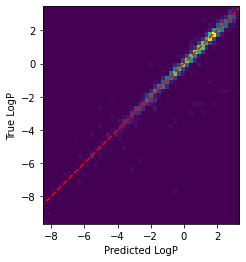

In [27]:
heatmap, xedges, yedges = np.histogram2d(preds, gts, bins=50) # (1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] # (2)

plt.clf()
plt.plot([min(gts), max(gts)], [min(gts), max(gts)], 'r--') # (3)
plt.imshow(heatmap.T, extent=extent, origin='lower') # (4)
plt.xlabel('Predicted LogP')
plt.ylabel('True LogP')
plt.show()

Note, there is a significant improvement in the correlation between predicted and ground truth logP values, as indicated by the stronger diagonal line in the heatmap.